## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch
# !pip install torch torchvision torchaudio

# # Install additional dependencies
# !pip install matplotlib pandas pillow tqdm

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Loading and Exploring the Dataset

### Setting the Dataset Path

In [3]:
dataset_path = Path("./bird_coco_rle")

### Getting the Image and Annotation Folders

In [4]:
 # Assuming the images are stored in a subfolder named 'images'
img_dir = dataset_path/'images/'

# Assuming the annotation file is in JSON format and located in a subdirectory of the dataset
annotation_file_path = list(dataset_path.glob('*/*.json'))[0]

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Image Folder": img_dir, 
    "Annotation File": annotation_file_path}).to_frame().style.hide(axis='columns')

Image Folder,bird_coco_rle/images
Annotation File,bird_coco_rle/annotations/instances_default.json


### Get Image File Paths

In [5]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for file in get_img_files(img_dir) # Get a list of image files in the image directory
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 1


,0
pexels-klaus-machtel-2147699903-29726961,bird_coco_rle/images/pexels-klaus-machtel-2147699903-29726961.jpg


### Get Image Annotations

#### Load the annotation file into a DataFrame

In [6]:
# Read the JSON file into a DataFrame, assuming the JSON is oriented by index
annotation_file_df = pd.read_json(annotation_file_path, orient='index').transpose()
annotation_file_df.head()

,licenses,info,categories,images,annotations
0,"{'name': '', 'id': 0, 'url': ''}",contributor,"{'id': 1, 'name': 'bird', 'supercategory': ''}","{'id': 1, 'width': 1280, 'height': 914, 'file_name': 'pexels-klaus-machtel-2147699903-29726961.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': {'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}, 'area': 68692.0, 'bbox': [699.0, 250.0, 406.0, 399.0], 'iscrowd': 1, 'attributes': {'occluded': False}}"
1,None,date_created,None,None,None
2,None,description,None,None,None
3,None,url,None,None,None
4,None,version,None,None,None


#### Extract the image informationExtract the object classes

In [7]:
# Extract and transform the 'categories' section of the data
# This DataFrame contains category details like category ID and name
categories_df = annotation_file_df['categories'].dropna().apply(pd.Series)
categories_df.set_index('id', inplace=True)
categories_df

,name,supercategory
id,,
1,bird,


#### Extract the image information

In [8]:
# Extract and transform the 'images' section of the data
# This DataFrame contains image details like file name, height, width, and image ID
images_df = annotation_file_df['images'].to_frame()['images'].apply(pd.Series)[['file_name', 'height', 'width', 'id']]
images_df.head()

,file_name,height,width,id
0,pexels-klaus-machtel-2147699903-29726961.jpg,914.0,1280.0,1.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [9]:
# Drop rows where all values are NaN
images_df = images_df.dropna(how='all')
images_df.head()

,file_name,height,width,id
0,pexels-klaus-machtel-2147699903-29726961.jpg,914.0,1280.0,1.0


#### Extract the annotation information

In [10]:
# Extract and transform the 'annotations' section of the data
# This DataFrame contains annotation details like image ID, segmentation points, bounding box, and category ID
annotations_df = annotation_file_df['annotations'].to_frame()['annotations'].apply(pd.Series)[['image_id', 'segmentation', 'bbox', 'category_id']]
annotations_df.head()

,image_id,segmentation,bbox,category_id
0,1.0,"{'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}","[699.0, 250.0, 406.0, 399.0]",1.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [11]:
# Drop rows where all values are NaN
annotations_df = annotations_df.dropna(how='all')
annotations_df.head()

,image_id,segmentation,bbox,category_id
0,1.0,"{'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}","[699.0, 250.0, 406.0, 399.0]",1.0


#### Add the class names to the annotations

In [12]:
# Map 'category_id' in annotations DataFrame to category name using categories DataFrame
annotations_df['label'] = annotations_df['category_id'].apply(lambda x: categories_df.loc[x]['name'])
annotations_df.head()

,image_id,segmentation,bbox,category_id,label
0,1.0,"{'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}","[699.0, 250.0, 406.0, 399.0]",1.0,bird


#### Merge the image and  annotation information

In [13]:
# Merge annotations DataFrame with images DataFrame on their image ID
annotation_df = pd.merge(annotations_df, images_df, left_on='image_id', right_on='id')
annotation_df.head()

,image_id,segmentation,bbox,category_id,label,file_name,height,width,id
0,1.0,"{'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}","[699.0, 250.0, 406.0, 399.0]",1.0,bird,pexels-klaus-machtel-2147699903-29726961.jpg,914.0,1280.0,1.0


#### Use the image name as the index

In [14]:
# Remove old 'id' column post-merge
annotation_df.drop('id', axis=1, inplace=True)

# Extract the image_id from the file_name (assuming file_name contains the image_id)
annotation_df['image_id'] = annotation_df['file_name'].apply(lambda x: x.split('.')[0])

# Set 'image_id' as the index for the DataFrame
annotation_df.set_index('image_id', inplace=True)
annotation_df.head()

,segmentation,bbox,category_id,label,file_name,height,width
image_id,,,,,,,
pexels-klaus-machtel-2147699903-29726961,"{'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}","[699.0, 250.0, 406.0, 399.0]",1.0,bird,pexels-klaus-machtel-2147699903-29726961.jpg,914.0,1280.0


#### Group annotations by image

In [15]:
# Group the data by 'image_id' and aggregate information
annotation_df = annotation_df.groupby('image_id').agg({
    'segmentation': list,
    'bbox': list, 
    'category_id': list,
    'label' :list,
    'file_name': 'first', 
    'height': 'first', 
    'width': 'first'
})

# Rename columns for clarity 
# 'bbox' is renamed to 'bboxes' and 'label' to 'labels'
annotation_df.rename(columns={'bbox': 'bboxes', 'label': 'labels'}, inplace=True)
annotation_df.head()

,segmentation,bboxes,category_id,labels,file_name,height,width
image_id,,,,,,,
pexels-klaus-machtel-2147699903-29726961,"[{'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}]","[[699.0, 250.0, 406.0, 399.0]]",[1.0],[bird],pexels-klaus-machtel-2147699903-29726961.jpg,914.0,1280.0


### Inspecting the Class Distribution

#### Get image classes

In [16]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = annotation_df['labels'].explode().unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,bird


#### Visualize the class distribution

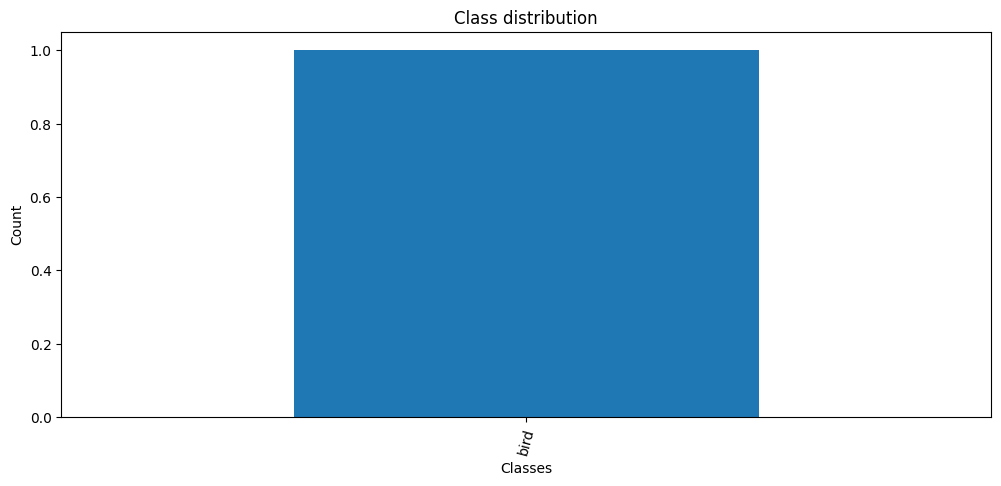

In [17]:
# Get the number of samples for each object class
class_counts = pd.DataFrame(annotation_df['labels'].explode().tolist()).value_counts()#.sort_index()

plot_labels = [index[0] for index in class_counts.index]

# Plot the distribution
class_counts.plot(kind='bar', figsize=(12, 5))
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), plot_labels, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Image Annotations

#### Generate a color map

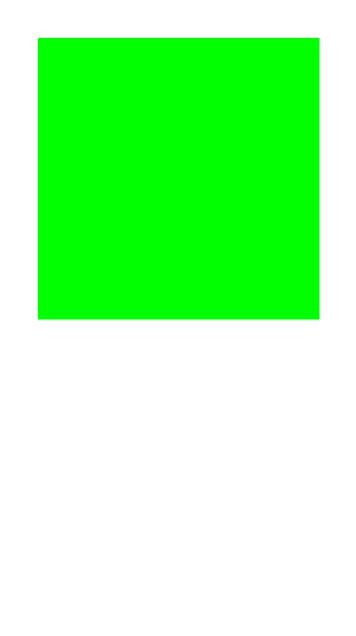

In [18]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [19]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [20]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (1280, 914)


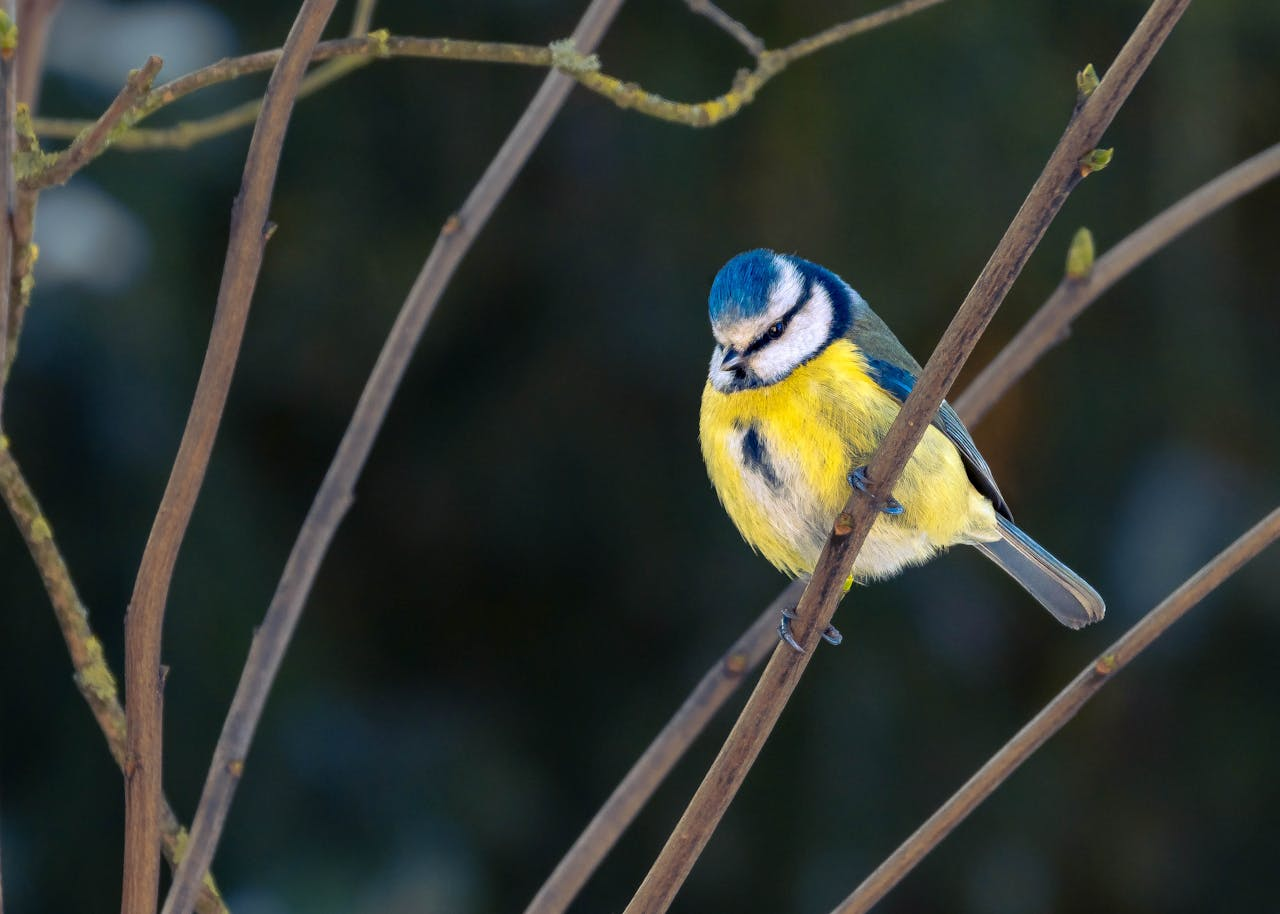

In [21]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [22]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,pexels-klaus-machtel-2147699903-29726961
segmentation,"[{'counts': [639315, 3, 890, 37, 869, 52, 856, 61, 849, 69, 841, 76, 835, 82, 829, 88, 821, 96, 814, 103, 740, 20, 45, 112, 730, 34, 33, 120, 722, 44, 25, 125, 718, 50, 16, 132, 714, 55, 11, 137, 710, 60, 4, 142, 706, 210, 701, 215, 697, 219, 693, 223, 689, 227, 686, 231, 681, 235, 678, 237, 676, 240, 673, 243, 670, 245, 668, 248, 665, 251, 663, 252, 661, 254, 659, 257, 656, 260, 653, 263, 650, 265, 649, 266, 648, 268, 645, 271, 643, 273, 640, 275, 639, 277, 636, 279, 634, 282, 632, 283, ...], 'size': [914, 1280]}]"
bboxes,"[[699.0, 250.0, 406.0, 399.0]]"
category_id,[1.0]
labels,[bird]
file_name,pexels-klaus-machtel-2147699903-29726961.jpg
height,914.0
width,1280.0


#### Define a function to decode COCO-format RLE

In [23]:
def decode_rle(counts, size):
    """
    Decode COCO-format RLE to a binary mask numpy array of shape (height, width).
    counts: list of integers describing the run-length encoding
    shape: tuple (height, width)
    """
    h, w = size
    # Total number of pixels
    total_pixels = h * w
    
    # Initialize a flat array of zeros
    mask = np.zeros(total_pixels, dtype=np.uint8)
    
    # RLE format alternates between counts of off and on pixels
    # Start index
    idx = 0
    for i, count in enumerate(counts):
        if i % 2 == 1:
            # These are "on" runs; set these pixels to 1
            mask[idx: idx + count] = 1
        # Move the index forward by the current count, regardless of off or on
        idx += count

    # Reshape using column-major (Fortran) order
    mask = mask.reshape((h, w), order='F')
    return mask

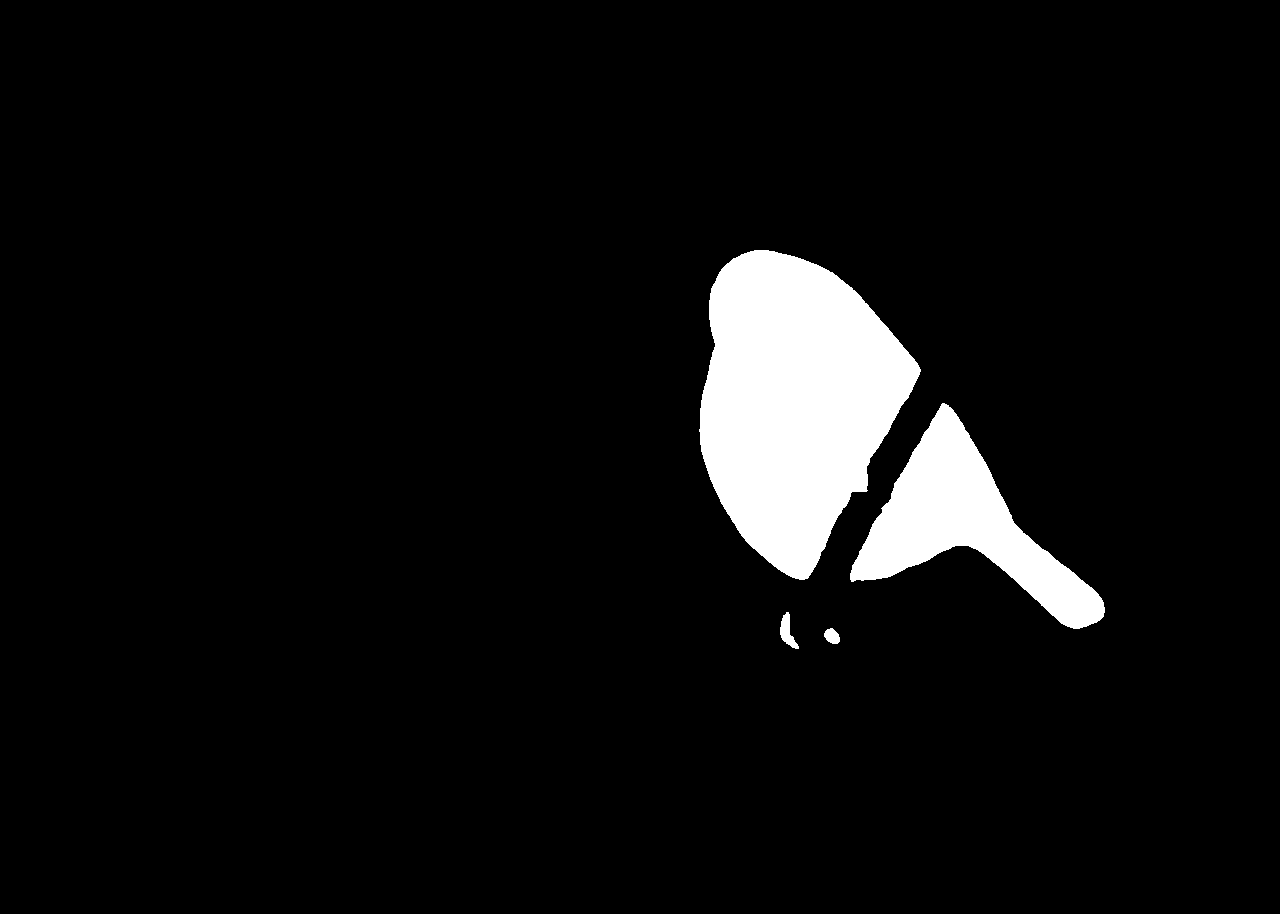

In [24]:
rle = annotation_df.loc[file_id]['segmentation'][0]["counts"]
h, w = annotation_df.loc[file_id]["segmentation"][0]["size"]

# Decode RLE to mask
mask_array = decode_rle(rle, (h, w))

# Convert to PIL Image
# Multiply by 255 to get a visible binary mask (0 or 255)
mask_image = Image.fromarray((mask_array * 255).astype(np.uint8), mode='L')

# Display the mask
mask_image

#### Annotate sample image

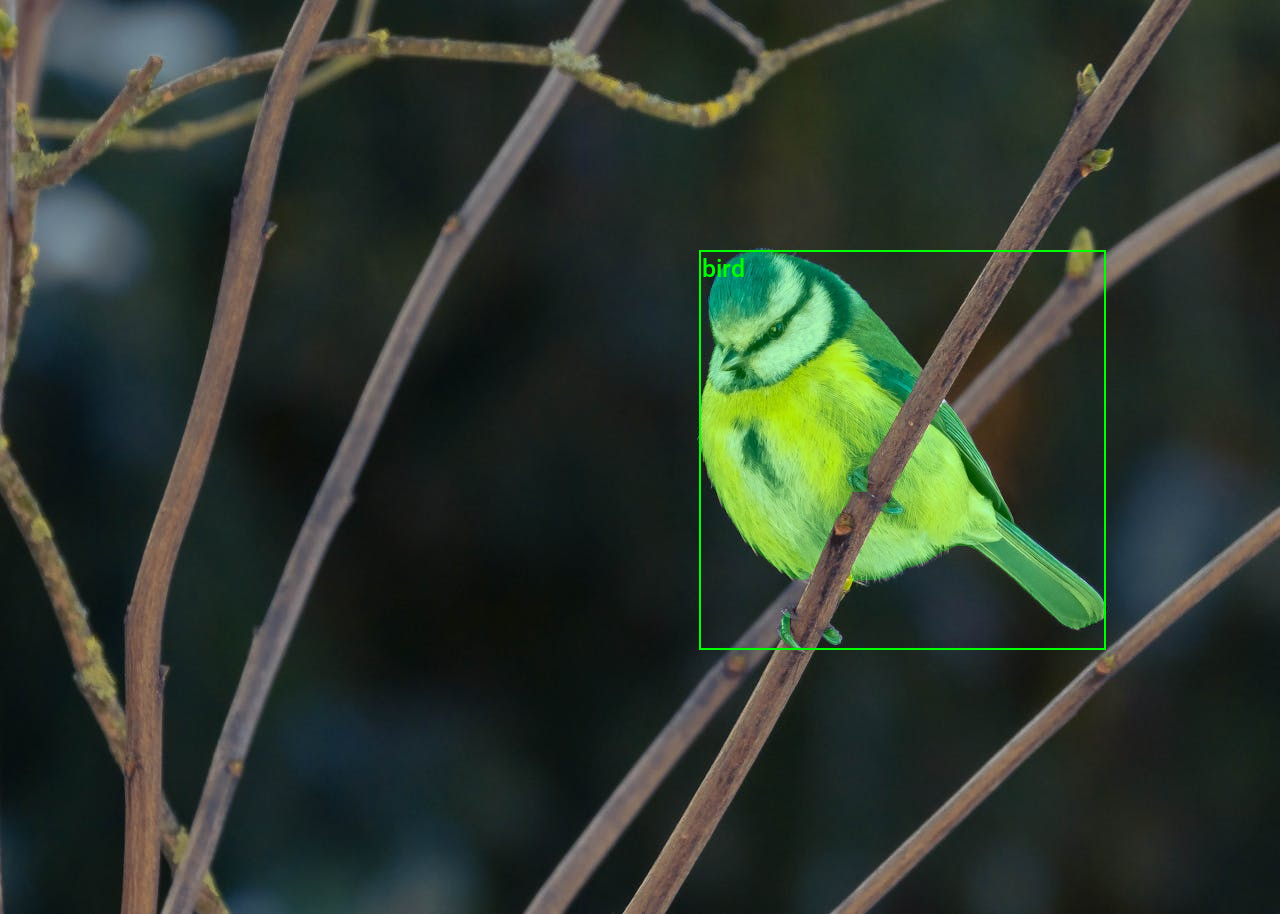

In [25]:
# Extract the RLE data for segmentation mask
rle_data = annotation_df.loc[file_id]['segmentation']

# Generate mask images from RLE data
mask_imgs = [Image.fromarray((decode_rle(**item)*255).astype(np.uint8), mode='L') for item in rle_data]

# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

# Extract the labels and bounding box annotations for the sample image
labels = annotation_df.loc[file_id]['labels']
bboxes = annotation_df.loc[file_id]['bboxes']

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [26]:
# Set training image size
train_sz = 384

#### Initialize the custom transforms

In [27]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

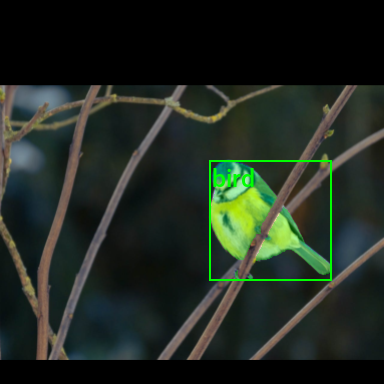

Source Image:,"(1280, 914)"
Cropped Image:,"(1280, 914)"
Resized Image:,"(383, 274)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [28]:
# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'), 
                           format='xyxy', 
                           canvas_size=sample_img.size[::-1]), 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [29]:
class COCOInstSegRLEDataset(Dataset):
    """
    A PyTorch Dataset class for COCO-style instance segmentation.

    This class is designed to handle datasets for instance segmentation tasks, specifically
    formatted in the style of COCO (Common Objects in Context) annotations. It supports
    loading images along with their corresponding segmentation masks and bounding boxes.

    Attributes:
    _img_keys : list
        List of image keys (identifiers).
    _annotation_df : pandas.DataFrame
        DataFrame containing annotations for images.
    _img_dict : dict
        Dictionary mapping image keys to their file paths.
    _class_to_idx : dict
        Dictionary mapping class names to class indices.
    _transforms : torchvision.transforms (optional)
        Transformations to be applied to the images and targets.

    Methods:
    __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        Initializes the dataset with image keys, annotations, image dictionary,
        class mappings, and optional transforms.
    __len__(self):
        Returns the total number of items in the dataset.
    __getitem__(self, index):
        Retrieves an image and its corresponding target (masks, boxes, labels) by index.
    _load_image_and_target(self, annotation):
        Loads an image and its corresponding target data based on the providedannotation.

    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Initializes the COCOInstSegRLEDataset instance.

        Parameters:
            img_keys (list): List of image keys.
            annotation_df (DataFrame): DataFrame containing image annotations.
            img_dict (dict): Dictionary mapping image keys to file paths.
            class_to_idx (dict): Dictionary mapping class names to indices.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied

    def __len__(self):
        # Returns the number of items in the dataset
        return len(self._img_keys)
        
    def __getitem__(self, index):
        # Retrieves an image and its corresponding target by index
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        
        # Apply transformations if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        # Loads an image and its corresponding target data (masks, boxes, labels)
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')

        # Process RLE data
        rle_data = annotation['segmentation']
        mask_imgs = [Image.fromarray((decode_rle(**item)*255).astype(np.uint8), mode='L') for item in rle_data]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))
        
        # Convert bounding boxes to tensor format
        bbox_list = annotation['bboxes']
        bbox_tensor = torchvision.ops.box_convert(torch.Tensor(bbox_list), 'xywh', 'xyxy')
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])
        
        # Map labels to their corresponding indices
        annotation_labels = annotation['labels']
        labels = torch.Tensor([self._class_to_idx[label] for label in annotation_labels])
        
        return image, {'masks': masks, 'boxes': boxes, 'labels': labels}

### Image Transforms

In [30]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

### Initialize Dataset

In [31]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = COCOInstSegRLEDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,1


### Inspect Samples

#### Inspect training set sample

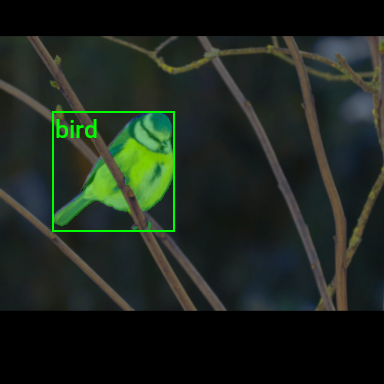

In [32]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)